In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_id = pd.read_csv('/Users/zeyangyu/Desktop/train_identity.csv')
train_transaction = pd.read_csv('/Users/zeyangyu/Desktop/train_transaction.csv')
train = train_transaction.merge(train_id,on=['TransactionID'],how='left')
fraud = train[train['isFraud'] ==1]
notFraud = train[train['isFraud'] ==0]
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


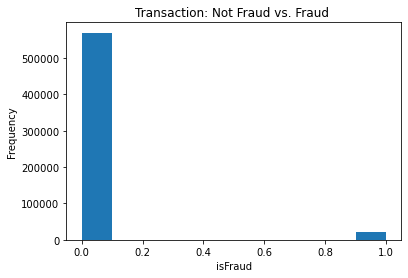

In [3]:
isFraud =  train['isFraud']
plt.hist(isFraud)
plt.title("Transaction: Not Fraud vs. Fraud ")
plt.xlabel("isFraud")
plt.ylabel("Frequency")
plt.show()

In [4]:
Not_fraud=train[train.isFraud==0]
Fraud=train[train.isFraud==1]
Not_fraud_undersampled = resample(Not_fraud,
                               replace=True,
                               n_samples=len(Fraud),
                               random_state=27) # reproducible results
df = pd.concat([Fraud, Not_fraud_undersampled])

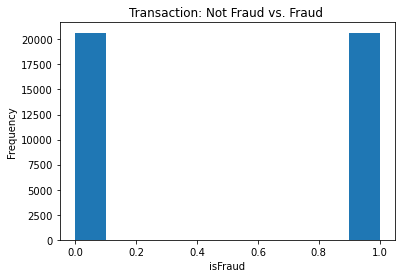

In [5]:
isFraud = df['isFraud']
plt.hist(isFraud)
plt.title("Transaction: Not Fraud vs. Fraud ")
plt.xlabel("isFraud")
plt.ylabel("Frequency")
plt.show()

Credit imputation

In [6]:
df['isCredit'] = (df['card6'] == 'credit') *1

Transaction amount: TransactionAmt(numeric), if_amount < 20 (1,0), Amount.group (categorical)

In [7]:
# fill na 
df['TransactionAmt'].fillna(df['TransactionAmt'].mean(), inplace=True) 
# set bins for the Transaction amount
listbins = [0,15,50,100,300,2000,1000000000]
listlabel = ['1','2','3','4','5','6']
df['Amount.group']=pd.cut(df['TransactionAmt'],
                             bins = listbins,labels = listlabel,right = False,include_lowest=True)
df['if_amount < 20'] = (df['TransactionAmt'] < 20) * 1 #DRAW PIE CHART/FORM

Card 4: Financial Services Corporation

In [8]:
df['isDiscovery'] = (df['card4'] == 'discover') *1

ProductCD

In [9]:
df['isProductC'] = (df['ProductCD'] == 'C') *1

DeviceType

In [10]:
# one hot encoding 
df['isMobile'] = (df['DeviceType'] == 'mobile') *1
df['isDesktop'] = (df['DeviceType'] == 'desktop') *1

Other useful variable, which is hard to explain

In [11]:
# fill na , data imputation
df['V288'].fillna(df['V288'].median(), inplace=True) 
df['V282'].fillna(df['V282'].median(), inplace=True) 
df['V285'].fillna(df['V285'].median(), inplace=True) 
df['V286'].fillna(df['V286'].median(), inplace=True) 
df['V287'].fillna(df['V287'].median(), inplace=True) 
df['V284'].fillna(df['V284'].median(), inplace=True) 

In [12]:
df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_38,DeviceType,DeviceInfo,isCredit,Amount.group,if_amount < 20,isDiscovery,isProductC,isMobile,isDesktop
203,2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,1,5,0,0,0,0,0
240,2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,...,T,mobile,Redmi Note 4 Build/MMB29M,1,2,0,0,1,1,0
243,2987243,1,90246,37.098,C,13413,103.0,185.0,visa,137.0,...,T,mobile,Redmi Note 4 Build/MMB29M,1,2,0,0,1,1,0
245,2987245,1,90295,37.098,C,13413,103.0,185.0,visa,137.0,...,T,mobile,Redmi Note 4 Build/MMB29M,1,2,0,0,1,1,0
288,2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,...,F,mobile,NaN,1,4,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135549,3122549,0,2735318,8.629,C,3278,453.0,150.0,visa,226.0,...,T,mobile,NaN,0,1,1,0,1,1,0
219410,3206410,0,5157616,125.000,R,12839,321.0,150.0,visa,226.0,...,F,mobile,iOS Device,0,4,0,0,0,1,0
46840,3033840,0,1115029,250.000,R,16075,514.0,150.0,mastercard,102.0,...,F,mobile,iOS Device,1,4,0,0,0,1,0
563016,3550016,0,14922224,34.000,W,13307,428.0,150.0,visa,166.0,...,NaN,NaN,NaN,0,2,0,0,0,0,0


In [13]:
df_final = df.sample(frac=1)
y = df_final['isFraud']

In [14]:
y

464483    1
196665    0
447460    1
487081    1
492213    1
         ..
332536    0
585542    1
41146     1
428460    1
45004     0
Name: isFraud, Length: 41326, dtype: int64

Model

In [15]:
df_new = df_final[['isDiscovery','isMobile','isDesktop','isCredit','isProductC',
               'if_amount < 20','Amount.group',
               'V288','V282','V284','V285','V286','V287','isFraud']]

In [16]:
X_train,X_test,y_train,y_test=train_test_split(df_new.drop('isFraud',axis=1),
                                               y,test_size=.20,
                                               random_state=0,
                                               stratify=y)

We tried the following combination: if amt + transamt, if amt + amtgroup, if amt + transamt + amtgroup
over the same trainning & splitting data frames
amt + amtgroup has the highest accuracy

In [17]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((33060, 13), (33060,), (8266, 13), (8266,))

In [18]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7350592789741108

In [19]:
#confusion matrix 
y1 = np.array(y_test)
y_hat = np.array(clf.predict(X_test))
M = confusion_matrix(y_true=y1, y_pred=y_hat)
e = pd.DataFrame(data=M)
print('The confusion matrix is: ')
print(e)

The confusion matrix is: 
      0     1
0  3343   790
1  1400  2733


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

Ran = RandomForestClassifier(max_depth=1000, random_state=1)
Ran.fit(X_train, y_train)
Ran.score(X_test, y_test)

0.7377207839341883

In [21]:
# confusion matrix 2
y1 = np.array(y_test)
y_hat = np.array(Ran.predict(X_test))
M = confusion_matrix(y_true=y1, y_pred=y_hat)
e = pd.DataFrame(data=M)
print('The confusion matrix is: ')
print(e)

The confusion matrix is: 
      0     1
0  3304   829
1  1339  2794


In [22]:
# use Knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.6786837648197436

In [23]:
k_value =  [1, 3, 5, 7, 9, 11, 13, 14, 15, 20]
K_score =[]
for i in range(10):
    knn = KNeighborsClassifier(n_neighbors= k_value[i], metric='euclidean') # set grid search
    knn.fit(X_train, y_train) # fit the training data 
    K_score.append(knn.score(X_test, y_test))

(0.5, 0.77)

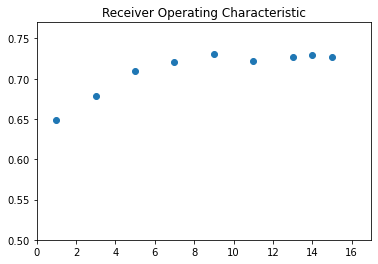

In [24]:
plt.title('Receiver Operating Characteristic')

plt.scatter(k_value , K_score)
plt.xlim([0, 17])
plt.ylim([0.5, 0.77])

In [25]:
K_score
# k = 14 is the best

[0.6491652552625212,
 0.6786837648197436,
 0.7096540043551899,
 0.721146866682797,
 0.7300992015485119,
 0.7224776191628357,
 0.7264698766029518,
 0.7288894265666586,
 0.7275586740866199,
 0.7265908541011372]

In [26]:
y1 = np.array(y_test)
y_hat = np.array(knn.predict(X_test))
M = confusion_matrix(y_true=y1, y_pred=y_hat)
e = pd.DataFrame(data=M)
print('The confusion matrix is: ')
print(e)

The confusion matrix is: 
      0     1
0  3169   964
1  1296  2837


knn = 14 , 

In [27]:
# logistic
from sklearn import svm, linear_model, datasets
model = linear_model.LogisticRegression(C =100)
model.fit(X_train,y_train)
model.score(X_test, y_test)

0.7102588918461166